In [ ]:
import os, sys

# adds the package path to the Python path to make sure all the local imports work fine 
if os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))) not in sys.path:
    sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))

import xarray as xr
from datetime import timedelta, datetime
import pandas as pd
from pathlib import Path

from wp4.constants import POLLUTANTS, DATA_DIR_CAMS

# Aggregated Air Quality Index

This notebook presents the calculation of an aggregated air quality index, as a way to combine information on different pollutants and represent it as a more comprehensible index, that indicates the air quality based on the standards on air quality set by the EPA. 

The methodology for combining multiple single air quality indices into and aggregated index was taken from the following paper:\
*Development of an aggregate Air Quality Index for an urban Mediterranean agglomeration: Relation to potential health effects* by George Kyrkilis, Arhontoula Chaloulakou & Pavlos A. Kassomenos (2007).

For the calculation of the separate indices the Air Quality Index for Health standards set by the EPA were used, see the table below or the following website:

https://airquality.ie/information/air-quality-index-for-health

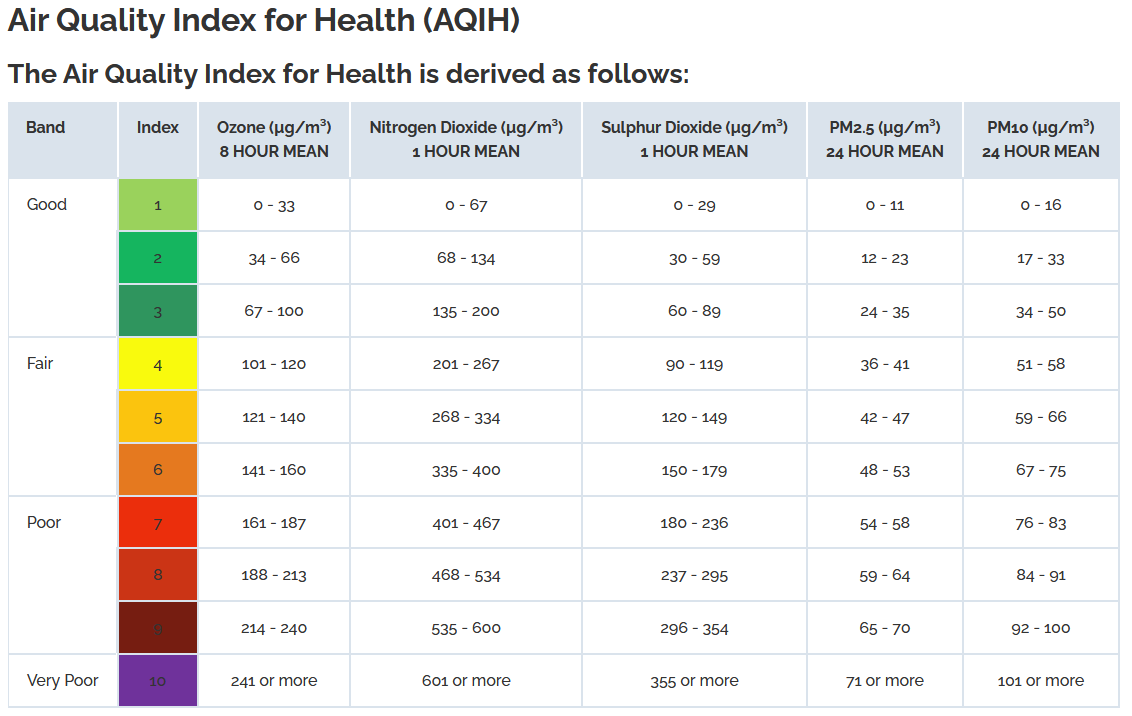

In [ ]:
# The following dictionaries contain the AQI score and the concentration ranges belonging to each AQI score

aqi_o3 = {
    'good_1':{
        'AQI':(0,15),
        'conc':(0,33)},
    'good_2':{
        'AQI':(16,30),
        'conc':(34,66)},
    'good_3':{
        'AQI':(31,50),
        'conc':(67,100)},
    'fair_4':{
        'AQI':(51,100),
        'conc':(101,120)},
    'fair_5':{
        'AQI':(101,150),
        'conc':(121,140)},
    'fair_6':{
        'AQI':(151,175),
        'conc':(141,160)},
    'poor_7':{
        'AQI':(176,200),
        'conc':(161,187)},
    'poor_8':{
        'AQI':(201,300),
        'conc':(188,213)},
    'poor_9':{
        'AQI':(301,400),
        'conc':(214,240)},
    'very_poor_10  ':{
        'AQI':(401,500),
        'conc':(241,10000)},
}

aqi_pm25 = {
    'good_1':{
        'AQI':(0,15),
        'conc':(0,11)},
    'good_2':{
        'AQI':(16,30),
        'conc':(12,23)},
    'good_3':{
        'AQI':(31,50),
        'conc':(24,35)},
    'fair_4':{
        'AQI':(51,100),
        'conc':(36,41)},
    'fair_5':{
        'AQI':(101,150),
        'conc':(42,47)},
    'fair_6':{
        'AQI':(151,175),
        'conc':(48,53)},
    'poor_7':{
        'AQI':(176,200),
        'conc':(54,58)},
    'poor_8':{
        'AQI':(201,300),
        'conc':(59,64)},
    'poor_9':{
        'AQI':(301,400),
        'conc':(65,70)},
    'very_poor_10  ':{
        'AQI':(401,500),
        'conc':(71,10000)},
}

aqi_pm10 = {
    'good_1':{
        'AQI':(0,15),
        'conc':(0,16)},
    'good_2':{
        'AQI':(16,30),
        'conc':(17,33)},
    'good_3':{
        'AQI':(31,50),
        'conc':(34,50)},
    'fair_4':{
        'AQI':(51,100),
        'conc':(51,58)},
    'fair_5':{
        'AQI':(101,150),
        'conc':(59,66)},
    'fair_6':{
        'AQI':(151,175),
        'conc':(67,75)},
    'poor_7':{
        'AQI':(176,200),
        'conc':(76,83)},
    'poor_8':{
        'AQI':(201,300),
        'conc':(84,91)},
    'poor_9':{
        'AQI':(301,400),
        'conc':(92,100)},
    'very_poor_10  ':{
        'AQI':(401,500),
        'conc':(101,10000)},
}

aqi_so2 = {
    'good_1':{
        'AQI':(0,15),
        'conc':(0,29)},
    'good_2':{
        'AQI':(16,30),
        'conc':(30,59)},
    'good_3':{
        'AQI':(31,50),
        'conc':(60,89)},
    'fair_4':{
        'AQI':(51,100),
        'conc':(90,119)},
    'fair_5':{
        'AQI':(101,150),
        'conc':(120,149)},
    'fair_6':{
        'AQI':(151,175),
        'conc':(150,179)},
    'poor_7':{
        'AQI':(176,200),
        'conc':(180,236)},
    'poor_8':{
        'AQI':(201,300),
        'conc':(237,295)},
    'poor_9':{
        'AQI':(301,400),
        'conc':(296,354)},
    'very_poor_10  ':{
        'AQI':(401,500),
        'conc':(355,10000)},
}

aqi_no2 = {
    'good_1':{
        'AQI':(0,15),
        'conc':(0,67)},
    'good_2':{
        'AQI':(16,30),
        'conc':(68,134)},
    'good_3':{
        'AQI':(31,50),
        'conc':(135,200)},
    'fair_4':{
        'AQI':(51,100),
        'conc':(201,267)},
    'fair_5':{
        'AQI':(101,150),
        'conc':(268,334)},
    'fair_6':{
        'AQI':(151,175),
        'conc':(335,400)},
    'poor_7':{
        'AQI':(176,200),
        'conc':(401,467)},
    'poor_8':{
        'AQI':(201,300),
        'conc':(468,534)},
    'poor_9':{
        'AQI':(301,400),
        'conc':(535,600)},
    'very_poor_10  ':{
        'AQI':(401,500),
        'conc':(601,10000)},
}

## In the following code block a time window and  location must be specified for which the Air Quality Index will be calculated

In [ ]:
time_window = {
    'start':datetime(year=2020, month=6, day=1, hour = 12),
    'end':datetime(year=2020, month=6, day=4, hour = 12)
}

location = {
    'latitude':53.185123,
    'longitude':360 - 7.692896,
}

## Processing

In [ ]:
# load the datasets with the CAMS data to be used for the AQI calculation

datasets = {
    'O3': xr.open_dataset(Path(DATA_DIR_CAMS).joinpath(f'{POLLUTANTS["O3"]["CAMS"]}.nc')),
    'NO2': xr.open_dataset(Path(DATA_DIR_CAMS).joinpath(f'{POLLUTANTS["NO2"]["CAMS"]}.nc')),
    'SO2': xr.open_dataset(Path(DATA_DIR_CAMS).joinpath(f'{POLLUTANTS["SO2"]["CAMS"]}.nc')),
    'PM25': xr.open_dataset(Path(DATA_DIR_CAMS).joinpath(f'{POLLUTANTS["PM25"]["CAMS"]}.nc')),
    'PM10': xr.open_dataset(Path(DATA_DIR_CAMS).joinpath(f'{POLLUTANTS["PM10"]["CAMS"]}.nc')),
}

dataframes = []

for dataset in datasets.keys():
    
    # select the data belonging to the CAMS pixel closest to the given location
    ds_subset_loc = datasets[dataset].sel(
        latitude=location['latitude'],
        longitude=location['longitude'],
        level=0,
        method='nearest'
    )
    
    # select the data for the specified data, note that data is selected from 24 hours before
    # the start to calculate the 24h average
    
    ds_subset = ds_subset_loc.sel(time=slice(time_window['start'] - timedelta(hours=24), time_window['end']))
    
    
    # convert to a pandas dataframe 
    pd_array = ds_subset.to_pandas().drop(['level', 'latitude', 'longitude'], 1)
    
    # add to the list of dataframes
    dataframes += [pd_array.T]
    
# concatenate all the dataframes into a single dataframe
df_aq = pd.concat(dataframes).T
# calculate the concentrations used for the AQI, as specified in the table above
df_aq['o3_8hr_mean'] = df_aq['o3_conc'].rolling(window=8).mean().round()
df_aq['pm2p5_24hr_mean'] = df_aq['pm2p5_conc'].rolling(window=24).mean().round()
df_aq['pm10_24hr_mean'] = df_aq['pm10_conc'].rolling(window=24).mean().round()
df_aq['no2_1hr'] = df_aq['no2_conc'].round()
df_aq['so2_1hr'] = df_aq['so2_conc'].round()

df_aq = df_aq[time_window['start'] : time_window['end']]

## Calculate the AQI for each of the pollutant measures

This part is based on the paper by Kyrkilis et al. The AQI is calculated using the following formula:

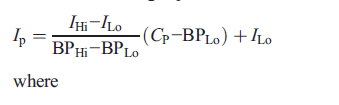

with

$I_{p}$ The index for pollutant $p$\
$C_{p}$ The rounded concentration of pollutant $p$\
$BP_{Hi}$ The breakpoint that is greater than or equal to $C_{p}$\
$BP_{Lo}$ The breakpoint that is less than or equal to $C_{p}$\
$I_{Hi}$ The Air Quality Index value corresponding to $BP_{Hi}$\
$I_{Lo}$ The Air Quality Index value corresponding to $BP_{Lo}$

In [ ]:
def get_o3_index(x):
   
    x = int(x)
    
    for level in aqi_o3.keys():
        if aqi_o3[level]['conc'][0] <= x <= aqi_o3[level]['conc'][1]:
            
            aqi_range = aqi_o3[level]['AQI']
            pol_range = aqi_o3[level]['conc']
            
            index = ((aqi_range[1] - aqi_range[0])/(pol_range[1] - pol_range[0]) * (x - pol_range[0])) + aqi_range[0]
            
            return round(index)
        
def get_no2_index(x):
   
    x = int(x)
    
    for level in aqi_no2.keys():
        if aqi_no2[level]['conc'][0] <= x <= aqi_no2[level]['conc'][1]:
            
            aqi_range = aqi_no2[level]['AQI']
            pol_range = aqi_no2[level]['conc']
            
            index = ((aqi_range[1] - aqi_range[0])/(pol_range[1] - pol_range[0]) * (x - pol_range[0])) + aqi_range[0]
            
            return round(index)
        
def get_pm25_index(x):
   
    x = int(x)
    
    for level in aqi_pm25.keys():
        if aqi_pm25[level]['conc'][0] <= x <= aqi_o3[level]['conc'][1]:
            
            aqi_range = aqi_pm25[level]['AQI']
            pol_range = aqi_pm25[level]['conc']
            
            index = ((aqi_range[1] - aqi_range[0])/(pol_range[1] - pol_range[0]) * (x - pol_range[0])) + aqi_range[0]
            
            return round(index)
        
def get_pm10_index(x):
   
    x = int(x)
    
    for level in aqi_pm10.keys():
        if aqi_pm10[level]['conc'][0] <= x <= aqi_pm10[level]['conc'][1]:
            
            aqi_range = aqi_pm10[level]['AQI']
            pol_range = aqi_pm10[level]['conc']
            
            index = ((aqi_range[1] - aqi_range[0])/(pol_range[1] - pol_range[0]) * (x - pol_range[0])) + aqi_range[0]
            
            return round(index)
        
def get_so2_index(x):
   
    x = int(x)
    
    for level in aqi_so2.keys():
        if aqi_so2[level]['conc'][0] <= x <= aqi_so2[level]['conc'][1]:
            
            aqi_range = aqi_so2[level]['AQI']
            pol_range = aqi_so2[level]['conc']
            
            index = ((aqi_range[1] - aqi_range[0])/(pol_range[1] - pol_range[0]) * (x - pol_range[0])) + aqi_range[0]
            
            return round(index)

In [ ]:
df_aq['o3_index'] = df_aq['o3_8hr_mean'].apply(get_o3_index)
df_aq['no2_index'] = df_aq['no2_1hr'].apply(get_no2_index)
df_aq['pm2p5_index'] = df_aq['pm2p5_24hr_mean'].apply(get_pm25_index)
df_aq['pm10_index'] = df_aq['pm10_24hr_mean'].apply(get_pm10_index)
df_aq['so2_index'] = df_aq['so2_1hr'].apply(get_so2_index)

## Next, calculate the aggregated index

The aggregated index is calculated using the following formula. 

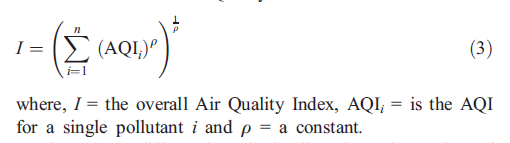

The value for the $\rho$ constant suggested by Kyrkilis et al. is 2.5. 

In [ ]:
df_aq['agg_aqi'] = df_aq[['o3_index', 'no2_index', 'pm2p5_index', 'pm10_index',
       'so2_index']].pow(2.5).sum(1).pow((1/2.5)).round()

## Finally, show  the result in a graph

In [ ]:
# Plotly
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

# make plot
        
fig = go.Figure()  # init a plotly figure
        
# Update xaxis properties
fig.update_xaxes(title_text="Date", showgrid=False)
        
# Update yaxis properties
fig.update_yaxes(title_text="Air Quality Indicator", showgrid=False)


fig.update_layout(
            template=pio.templates["seaborn"],
            autosize=False,
            width=1000,
            height=500
        )  # use the standard plotly dark template

fig.update_layout(legend=dict(  # position the legend
            yanchor="top",
            y=-0.2,
            xanchor="left",
            x=0.01))


background_colors = {
    'good_1':{
        'AQI':(0,15),
        'color':'#99d35c',
        'label':'Good',
    },
    'good_2':{
        'AQI':(15,30),
        'color':'#15b45f',
        'label':'Good',
    },
    'good_3':{
        'AQI':(30,50),
        'color':'#318e5b',
        'label':'Good',
    },
    'fair_4':{
        'AQI':(50,100),
        'color':'#fffa10',
        'label':'Fair',
    },
    'fair_5':{
        'AQI':(100,150),
        'color':'#ffc30f',
        'label':'Fair',
    },
    'fair_6':{
        'AQI':(150,175),
        'color':'#e4791e',
        'label':'Fair',
    },
    'poor_7':{
        'AQI':(175,200),
        'color':'#ff2d0e',
        'label':'Poor',
    },
    'poor_8':{
        'AQI':(200,300),
        'color':'#c7321e',
        'label':'Poor',
    },
    'poor_9':{
        'AQI':(300,400),
        'color':'#791a14',
        'label':'Poor',
    },
    'very_poor_10  ':{
        'AQI':(400,500),
        'color':'#7031a0',
        'label':'Very Poor',
    },
}

fig.update_yaxes(
        ticktext = [
            
        ],
        tickvals=[])

for cat in background_colors.keys():
    
    fig.add_hrect(
        y0=background_colors[cat]['AQI'][0],
        y1=background_colors[cat]['AQI'][1],
        line_width=0,
        fillcolor=background_colors[cat]['color'],
        layer='below',
        opacity=0.45
    )
    
    label_pos = (background_colors[cat]['AQI'][0] + background_colors[cat]['AQI'][1]) * .5
    
    fig.add_annotation(
        x=df_aq.reset_index()['time'][5],
        y=label_pos,
        text=background_colors[cat]['label'],
        showarrow=False,
        font=dict(
            size=13,
            color="Black"
    )
    )
    
fig.add_trace(go.Scatter(  # add the baseline values
            x=df_aq.reset_index()['time'],
            y=df_aq['agg_aqi'],
            mode='lines',
            name='AQI',
            line={'color': 'red', 'width':3}),
        )

min_val = 0
max_val = df_aq['agg_aqi'].max()

val_range = max_val - min_val
offset = val_range * 0.35  # small offset to prevent the plot from being too packed together
    
fig.update_layout(yaxis_range=[min_val, max_val + offset])

fig.show()